Youtube Data Analysis Project

1. We will be importing our basic libraries and functions in it.

In [1]:
import pandas as pd
import numpy as np
import json
from dateutil import parser
import isodate

# Google API for data 
from googleapiclient.discovery import build

# Libraries for Data Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Some NLP libraries
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
# from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRABHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PRABHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

2. Now We will bw creating an function for calling data from the youtube api. 

In [2]:
def youtube_api_runner(): 
    api_key = ''

    youtube_data = build('youtube', 'v3', developerKey=api_key)
    return youtube_data

3. Now we will be defining some functions here for different type of data we want to check or perform transformation on. 

In [3]:
def get_channel_stats(youtube_data, channel_ids): 
    all_data = []

    request = youtube_data.channels().list(
        part='snippet,contentDetails,statistics', 
        id=','.join(channel_ids))
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playListId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])

        all_data.append(data)

    return pd.DataFrame(all_data)

In [4]:
youtube_data = youtube_api_runner()

In [6]:
channel_ids = [
        'UCtYLUTtgS3k1Fg4y5tAhLbw', # Statquest
        'UCCezIgC97PvUuR4_gbFUs5g', # Corey Schafer
        'UCfzlCWGWYyIQ0aLC5w48gBQ', # Sentdex
        'UCNU_lfiiWBdtULKOw6X0Dig', # Krish Naik
        'UCzL_0nIe8B4-7ShhVPfJkgw', # DatascienceDoJo
        'UCLLw7jmFsvfIVaUFsLs8mlQ', # Luke Barousse 
        'UCiT9RITQ9PW6BhXK0y2jaeg', # Ken Jee
        'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the analyst
        'UC2UXDak6o7rBm23k3Vv5dww', # Tina Huang
    ]
# youtube_data_json = json.load(youtube_data)
# youtube_data_json = pd.DataFrame()
# youtube_data_json

channel_data = get_channel_stats(youtube_data, channel_ids)
channel_data

,channelName,subscribers,views,totalVideos,playListId
0,Luke Barousse,395000,19028164,146,UULLw7jmFsvfIVaUFsLs8mlQ
1,Alex The Analyst,641000,27195631,266,UU7cs8q-gJRlGwj4A8OmCmXg
2,Tina Huang,593000,27259027,162,UU2UXDak6o7rBm23k3Vv5dww
3,sentdex,1280000,112645852,1249,UUfzlCWGWYyIQ0aLC5w48gBQ
4,StatQuest with Josh Starmer,1050000,57063508,265,UUtYLUTtgS3k1Fg4y5tAhLbw
5,Corey Schafer,1240000,91123466,232,UUCezIgC97PvUuR4_gbFUs5g
6,Krish Naik,847000,85779772,1753,UUNU_lfiiWBdtULKOw6X0Dig
7,Data Science Dojo,101000,5724386,455,UUzL_0nIe8B4-7ShhVPfJkgw
8,Ken Jee,254000,8726436,286,UUiT9RITQ9PW6BhXK0y2jaeg


In [9]:
# type(channel_data[subscribers])
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

C:\Users\PRABHAT\AppData\Local\Temp\ipykernel_17924\1494984967.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


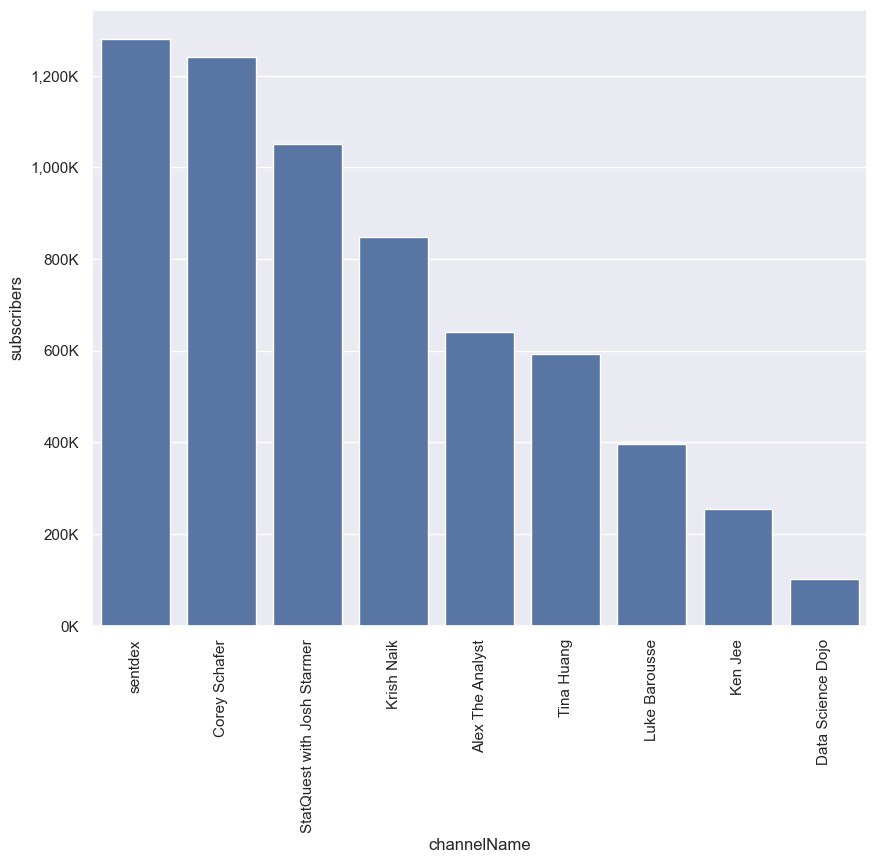

In [40]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)